# FMCW Radar 104 - Freq estimator

Goal:

> Compare apple to apple frequency estimators since Frequency estimation is key for distance measurement in FMCW radar

Summary:

| method | precision (% of 1 bin width) | comment |
|---|---|---|
| fft| +/- 50% | default |
| padding | -2% +0.5% | at 100x padding, unrealistic |
| quinn's 2nd | -1.25% +0.5% | simple |
| phase | -0.2% +0.7%  | **broken** (need to compensate for $s*\delta^2$|

> => Assuming a range bin/ resolution of $\frac{c}{2*B}$, a precision of 0.5% is equivalent to a precision of 0.2mm.

Next:
* Compensate for $s \cdot \delta^2$ phase shift in phase method.

History:

* 2022-Dec-17: fixed phase method and added summary values
* 2022-Dec-16: MRE code for each method to simplify comparisons
* 2022-Oct-13: added side by side comparison fft, padding, quinn's 2nd and phase
* ??: creation

Further reading:

sources for phase method:
* http://www.tsdconseil.fr/log/scriptscilab/festim/index-en.html
* https://www.dsprelated.com/showarticle/773.php

## MRE for frequency bin error computation

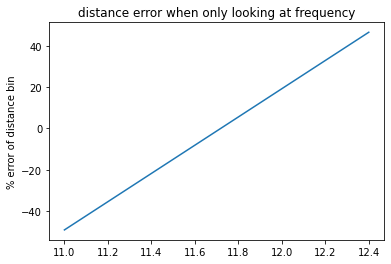

In [ ]:
from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan
import matplotlib.pyplot as plt
from scipy.fft import fft

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 2
Distance = 10
k = 10e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
antenna_rx = (0,0,0)
T = arange(0, n_samples*ts+ts, ts)

errors = []
distances = arange(11, 12.4, 0.01)
for d in distances:
  target = (0, d, 0)
  f_if = 2*k*d/c
  # sanity check
  assert f_if < 1/ts/2

  YIF = y_IF(f0_min, k, T, antenna_tx, antenna_rx, target)
  FT = fft(YIF)
  MAG = abs(FT)[0:int(n_samples/2)]
  ANG = angle(FT)[0:int(n_samples/2)]

  # now find the peak
  amplitude_peak = sorted(MAG, reverse = True)[0]
  i_peak = list(MAG).index(amplitude_peak)
  f_peak = i_peak * fs / n_samples
  d_calc = f_peak*c/2/k
  bin_size = fs*c/2/k/n_samples
  error = (d-d_calc)/bin_size
  errors.append(error*100)

plt.title("distance error when only looking at frequency")
plt.ylabel("% error of distance bin")
plt.plot(distances,errors)

## MRE for Quinn's second frequency estimation

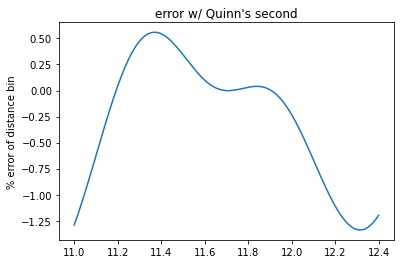

In [ ]:
from numpy import log,sqrt
from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan
import matplotlib.pyplot as plt
from scipy.fft import fft

def quinnsecond(FFT,k):
  """ Provide frequency estimator via Quinn's second estimate
  Parameters:
  -----------
    FFT:
    k:
  Returns:
  --------
    d:
  Details:
  --------
    C code source: https://gist.github.com/hiromorozumi/f74fd4d5592a7f79028560cb2922d05f
     out[k][0]  ... real part of FFT output at bin k
     out[k][1]  ... imaginary part of FFT output at bin k
  c++ code:
  divider = pow(out[k][0], 2.0) + pow(out[k][1], 2.0);
  ap = (out[k+1][0] * out[k][0] + out[k+1][1] * out[k][1]) / divider;
  dp = -ap  / (1.0 - ap);
  am = (out[k-1][0] * out[k][0] + out[k-1][1] * out[k][1]) / divider;

  dm = am / (1.0 - am);
  d = (dp + dm) / 2 + tau(dp * dp) - tau(dm * dm);
  """
  out = [[z.real, z.imag] for z in FFT]

  def tau(x):
    return 1/4* log(3*x**2 + 6*x + 1) - sqrt(6)/24 * log((x + 1 - sqrt(2/3)) / (x + 1 + sqrt(2/3)))

  divider = out[k][0]**2.0+ out[k][1]**2
  ap = (out[k+1][0] * out[k][0] + out[k+1][1] * out[k][1]) / divider
  dp = -ap  / (1.0 - ap)
  am = (out[k-1][0] * out[k][0] + out[k-1][1] * out[k][1]) / divider

  dm = am / (1.0 - am)
  d = (dp + dm) / 2 + tau(dp * dp) - tau(dm * dm)

  return d

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 2
Distance = 10
k = 10e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
antenna_rx = (0,0,0)
T = arange(0, n_samples*ts+ts, ts)

errors = []
distances = arange(11, 12.4, 0.01)
for d in distances:
  target = (0, d, 0)
  f_if = 2*k*d/c
  # sanity check
  assert f_if < 1/ts/2

  YIF = y_IF(f0_min, k, T, antenna_tx, antenna_rx, target)
  FT = fft(YIF)
  MAG = abs(FT)[0:int(n_samples/2)]
  ANG = angle(FT)[0:int(n_samples/2)]

  # now find the peak
  amplitude_peak = sorted(MAG, reverse = True)[0]
  i_peak = list(MAG).index(amplitude_peak)

  delta_i = quinnsecond(FT, i_peak)
  f1_estimate = fs*(i_peak+delta_i)/len(T)

  d_calc = f1_estimate*c/2/k
  bin_size = fs*c/2/k/n_samples
  error = (d-d_calc)/bin_size
  errors.append(error*100)

plt.title("error w/ Quinn's second")
plt.ylabel("% error of distance bin")
plt.plot(distances,errors)

## MRE for Zero Padding

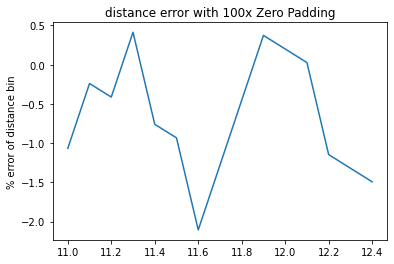

In [ ]:
from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan
import matplotlib.pyplot as plt
from scipy.fft import fft

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  # delta = sqrt((A.x-target.x)**2+(A.y-target.y)**2+(A.z-target.z)**2)/3e8
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 2
Distance = 10
k = 10e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
antenna_rx = (0,0,0)
T = arange(0, n_samples*ts+ts, ts)

resize_factor = 100
n_samples_resized = n_samples * resize_factor
errors = []
distances = arange(11, 12.4, 0.1)
for d in distances:
  target = (0, d, 0)
  f_if = 2*k*d/c
  # sanity check
  assert f_if < 1/ts/2

  YIF = y_IF(f0_min, k, T, antenna_tx, antenna_rx, target)
  YIF.resize(n_samples_resized)
  FT = fft(YIF)
  MAG = abs(FT)[0:int(n_samples_resized/2)]
  ANG = angle(FT)[0:int(n_samples_resized/2)]

  # now find the peak
  amplitude_peak = sorted(MAG, reverse = True)[0]
  i_peak = list(MAG).index(amplitude_peak)
  f_peak = i_peak * fs / n_samples_resized
  d_calc = f_peak*c/2/k
  bin_size = fs*c/2/k/n_samples
  error = (d-d_calc)/bin_size
  errors.append(error*100)

plt.title("distance error with 100x Zero Padding")
plt.ylabel("% error of distance bin")
plt.plot(distances,errors)

## ~~MRE for PHASE to FREQ~~

len_T 512


Text(0, 0.5, '% error of distance bin')

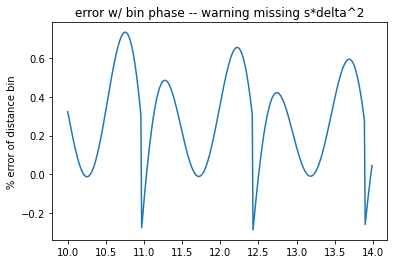

In [ ]:
#   / \
#  / ! \   THIS CODE IS BROKEN/ BUGGED / DO NOT USE
# /  !  \  the term # + slope * delta**2)) is commented out
#/   !   \ for real life usage this term needs to be compensated for

from numpy import abs ,angle, arange, arcsin, cos, pi, sqrt, tan
import matplotlib.pyplot as plt
from scipy.fft import fft

def y_IF(f0_min, slope, T, antenna_tx, antenna_rx, target, v=3e8):
  """ This function implements the mathematical IF defined in latex as
    y_{IF} = cos(2 \pi [f_0\delta + s * \delta * t - s* \delta^2])
  into following python code
  y_IF = cos (2*pi*(f_0 * delta + slope * delta * T + slope * delta**2))
  Parameters:
  -----------
  f0_min: float
    the frequency at the begining of the chirp
  slope: float
    the slope with which the chirp frequency inceases over time
  T: ndarray
    the 1D vector containing time values
  antenna_tx: tuple of floats
    x, y, z coordinates
  antenna_rx: tuple of floats
    x, y, z coordinates
  target: tuple of floats
    x, y, z coordinates
  v: float
    speed of light in considered medium
  Returns:
  --------
  YIF: ndarray
    vector containing the IF values
  """
  tx_x, tx_y, tx_z = antenna_tx
  rx_x, rx_y, rx_z = antenna_rx
  t_x, t_y, t_z = target
  distance = sqrt((tx_x-t_x)**2 + (tx_y-t_y)**2 + (tx_z-t_z)**2)
  distance += sqrt((rx_x-t_x)**2 + (rx_y-t_y)**2 + (rx_z-t_z)**2)
  delta = distance/v
  YIF = cos(2 *pi *(f0_min * delta + slope * delta * T)) # + slope * delta**2))
  return YIF

f0_min = 60e9
c = 3e8
# lambda ~5mm at 60GHz
lambda0_max = 3e8/f0_min
n_rx = 2
Distance = 10
k = 10e12
n_samples = 512
f_if = 2*k*Distance/c
fs = 50e6
ts = 1/fs

antenna_tx = (-lambda0_max/2,0,0)
antenna_rx = (0,0,0)
T = arange(0, n_samples*ts, ts)
print("len_T",len(T))
ns = n_samples//2

errors = []
phis = []
distances = arange(10, 14, 0.01)
for d in distances:
  target = (0, d, 0)
  f_if = 2*k*d/c
  # sanity check
  assert f_if < 1/ts/2

  YIF = y_IF(f0_min, k, T, antenna_tx, antenna_rx, target)
  FT = fft(YIF)
  MAG = abs(FT)[0:int(n_samples/2)]
  ANG = angle(FT)[0:int(n_samples/2)]

  # now find the peak
  amplitude_peak = sorted(MAG, reverse = True)[0]
  i_peak = list(MAG).index(amplitude_peak)

  # $$ \epsilon = \frac{\phi}{\pi}*\frac{N}{N-1} $$
  phi = ANG[i_peak]/pi
  epsilon = (phi)*(n_samples)/(n_samples-1) # *0.96 why does 0.96 seems to improve it ?!?
  # epsilon = 0
  f0_estimate = fs*(i_peak)/n_samples +fs*phi/(n_samples)
  # fft_bin_size = fs/n_samples
  # f_error = (f_if-f0_estimate)/fft_bin_size

  d_calc = f0_estimate*c/2/k
  d_error = d - d_calc
  bin_size = fs*c/2/k/n_samples
  error = (d-d_calc)/bin_size
  errors.append(error * 100)

plt.title("error w/ bin phase -- warning missing s*delta^2")
plt.plot(distances,errors)
plt.ylabel("% error of distance bin")


## BACK-UP

Not checked / not verified beyond this point

## DFT PHASE vs FREQ in 1 bin (from maths)

source: https://flylib.com/books/en/2.729.1/the_dft_frequency_response_to_a_complex_input.html

$$ X_c(m) = e^{j[\pi \cdot (k-m) - \pi \cdot \frac{k-m}{N}]} \cdot \frac{sin(\pi \cdot (k-m))}{sin(\pi \cdot \frac{k-m}{N})}$$

so
$$ \phi = \pi \cdot (k-m) - \pi \cdot \frac{k-m}{N} $$
$$ \frac{\phi}{\pi} = (k-m) \cdot \frac{N-1}{N} $$
$$ \epsilon = \frac{\phi}{\pi}*\frac{N}{N-1} $$

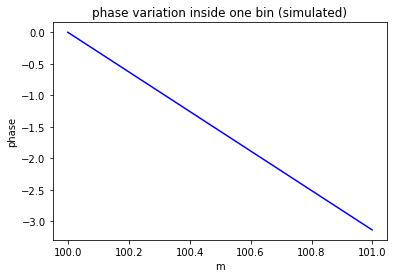

In [ ]:
from numpy.fft import fft, ifft,fftfreq
from numpy import abs, angle, arange, dot, exp, sin, pi
import matplotlib.pyplot as plt
from numpy import exp

def DFT_new(x):
    """
    Function to calculate the
    discrete Fourier Transform
    of a 1D real-valued signal x
    """

    N = len(x)
    n = arange(N)
    k = n.reshape((N, 1))
    e = exp(-2j * pi * k * n / N)

    X = dot(e, x)

    return X

def dft_resp(k,m,N):
  """ function to provide the DFT response from the explicit formula from book
  """
  if k==m:
    return N,0
  #dft = exp(1j*pi*((k-m)-(k-m)/N))*sin(pi*(k-m))/sin(pi*(k-m)/N)
  val = exp(1j*pi*((k-m)-(k-m)/N))*sin(pi*(k-m))/sin(pi*(k-m)/N)
  return abs(val),angle(val)

def plot_phase(N=1024):
  k=100
  phases = []
  offsets = range(1000)
  ms = []
  for offset in offsets:
    m=k+offset/1e3
    _, phase = dft_resp(k,m,N)
    phases.append(phase)
    ms.append(m)
  plt.title("phase variation inside one bin (simulated)")
  plt.plot(ms,phases,'b')
  plt.xlabel('m')
  plt.ylabel('phase')
plot_phase()

## DFT PHASE vs FREQ in 1 bin (from FFT)

done


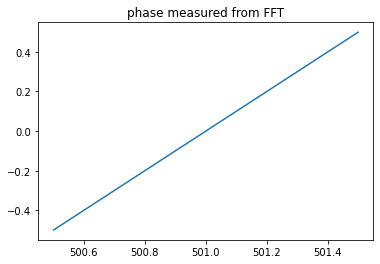

In [ ]:
# phase measurement with FFT
n_fft = 2000 #FFT points
fs= 2000 #sampling frequency
phases = []
fos = []
for fo in range(1,1000):
  f0 = 500.5+fo/1000 #signal frequency
  assert fs > 2*f0
  T = arange(0,n_fft/fs,1/fs)
  Y = sin(2*pi*f0*T+pi/2)
  FFT = fft(Y)
  MAG = abs(FFT)
  PHASE = angle(FFT)

  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  PHASE = PHASE[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude) #for peak in sorted_magnitude][0]
  fp = MAG[fpeak]
  ph_p = PHASE[fpeak]/pi
  phases.append(ph_p)
  fos.append(f0)
print("done")
plt.title("phase measured from FFT")
plt.plot(fos,phases)

## FREQ from PHASE

checking interpolation from phase to freq - seems to work down to 0.003mm

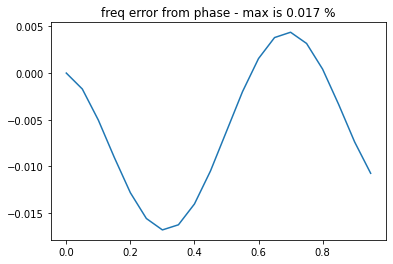

In [ ]:
#from v0.3 but backward: freq from phase
#freq accuracy at 2000 points ~ 1/1000th better than FFT
#FFT gives 3cm, phase gives <-> 0.003mm
fs = 2000
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts)
f0 = 500.5
n_increments=8000
phases = []
f1s = []
Xs = []
Ys = []

#for f1 in [200.6,200.55,200.732,200.8855]:
#for f1o in [.1,.05,.232,.3855]:
for f1o in arange(0,1,0.05):
  f1=f0+f1o
  Y=sin(2*pi*f1*T)
  FFT = fft(Y)
  MAG = abs(FFT)
  ANG = angle(FFT)
  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  ANG = ANG[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude)
  ph_peak = ANG[fpeak]

  epsilon_estimate = (ph_peak+pi)/(pi*(1-1/n_increments)) #+pi*()
  f1_estimate = f0+epsilon_estimate
  Xs.append(f1o)
  Ys.append((f1-f1_estimate)*100)
max_error = max(abs(Ys))
plt.title(f"freq error from phase - max is {max_error:.2g} %")
plt.plot(Xs, Ys)
plt.show()

## Back-up #2

> prep and research code (back-up)

## Quinn's second order

In [ ]:
from numpy import log,sqrt

def quinnsecond(FFT,k):
  """ Provide frequency estimator via Quinn's second estimate
  Parameters:
  -----------
    FFT:
    k:
  Returns:
  --------
    d:
  Details:
  --------
    C code source: https://gist.github.com/hiromorozumi/f74fd4d5592a7f79028560cb2922d05f
     out[k][0]  ... real part of FFT output at bin k
     out[k][1]  ... imaginary part of FFT output at bin k
  c++ code:
  divider = pow(out[k][0], 2.0) + pow(out[k][1], 2.0);
  ap = (out[k+1][0] * out[k][0] + out[k+1][1] * out[k][1]) / divider;
  dp = -ap  / (1.0 - ap);
  am = (out[k-1][0] * out[k][0] + out[k-1][1] * out[k][1]) / divider;

  dm = am / (1.0 - am);
  d = (dp + dm) / 2 + tau(dp * dp) - tau(dm * dm);
  """
  out = [[z.real, z.imag] for z in FFT]

  def tau(x):
    return 1/4* log(3*x**2 + 6*x + 1) - sqrt(6)/24 * log((x + 1 - sqrt(2/3)) / (x + 1 + sqrt(2/3)))

  divider = out[k][0]**2.0+ out[k][1]**2
  ap = (out[k+1][0] * out[k][0] + out[k+1][1] * out[k][1]) / divider
  dp = -ap  / (1.0 - ap)
  am = (out[k-1][0] * out[k][0] + out[k-1][1] * out[k][1]) / divider

  dm = am / (1.0 - am)
  d = (dp + dm) / 2 + tau(dp * dp) - tau(dm * dm)

  return d

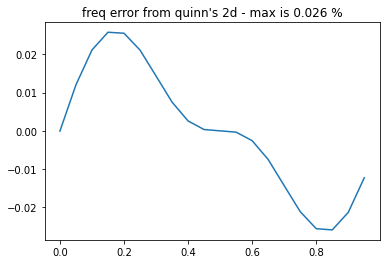

In [ ]:
fs = 2000
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts)
f0 = 500.5
n_increments=8000
phases = []
f1s = []
Xq = []
Yq = []
fft_size = len(T)

#for f1 in [200.6,200.55,200.732,200.8855]:
#for f1o in [.1,.05,.232,.3855]:
for f1o in arange(0,1,0.05):
  f1=f0+f1o
  Y=sin(2*pi*f1*T)
  FFT = fft(Y)
  MAG = abs(FFT)
  ANG = angle(FFT)
  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  ANG = ANG[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude)
  ph_peak = ANG[fpeak]

  #epsilon_estimate = (ph_peak+pi)/(pi*(1-1/n_increments)) #+pi*()
  #f1_estimate = f0+epsilon_estimate

  d = quinnsecond(FFT,fpeak)
  f1_estimate = 1/ts*(fpeak+d)/fft_size

  Xq.append(f1o)
  Yq.append((f1-f1_estimate)*100)
max_error = max(abs(Yq))
plt.title(f"freq error from quinn's 2d - max is {max_error:.2g} %")
plt.plot(Xq, Yq)
plt.show()

## PHASE to FREQ

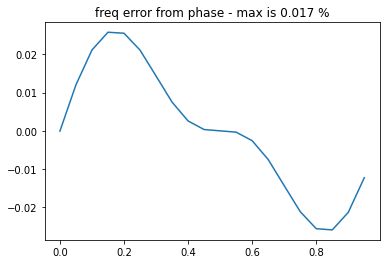

In [ ]:
#from v0.3 but backward: freq from phase
#freq accuracy at 2000 points ~ 1/1000th better than FFT
#FFT gives 3cm, phase gives <-> 0.003mm
fs = 2000
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts)
f0 = 500.5
n_increments=8000
phases = []
f1s = []
Xfs = []
Yfs = []

#for f1 in [200.6,200.55,200.732,200.8855]:
#for f1o in [.1,.05,.232,.3855]:
for f1o in arange(0,1,0.05):
  f1=f0+f1o
  Y=sin(2*pi*f1*T)
  FFT = fft(Y)
  MAG = abs(FFT)
  ANG = angle(FFT)
  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  ANG = ANG[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude)
  ph_peak = ANG[fpeak]

  epsilon_estimate = (ph_peak+pi)/(pi*(1-1/n_increments)) #+pi*()
  f1_estimate = f0+epsilon_estimate
  Xfs.append(f1o)
  Yfs.append((f1-f1_estimate)*100)
max_error = max(abs(Yfs))
plt.title(f"freq error from phase - max is {max_error:.2g} %")
plt.plot(Xs, Ys)
plt.show()

## no code

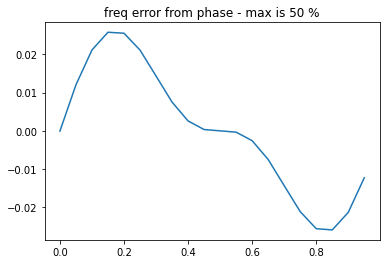

In [ ]:
#from v0.3 but backward: freq from phase
#freq accuracy at 2000 points ~ 1/1000th better than FFT
#FFT gives 3cm, phase gives <-> 0.003mm
fs = 2000
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts)
f0 = 500.5
n_increments=8000
phases = []
f1s = []
Xzs = []
Yzs = []

#for f1 in [200.6,200.55,200.732,200.8855]:
#for f1o in [.1,.05,.232,.3855]:
for f1o in arange(0,1,0.05):
  f1=f0+f1o
  Y=sin(2*pi*f1*T)
  FFT = fft(Y)
  MAG = abs(FFT)
  ANG = angle(FFT)
  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  ANG = ANG[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude)
  ph_peak = ANG[fpeak]

  f1_estimate = fpeak
  Xzs.append(f1o)
  Yzs.append((f1-f1_estimate)*100)
max_error = max(abs(Yzs))
plt.title(f"freq error from phase - max is {max_error:.2g} %")
plt.plot(Xs, Ys)
plt.show()

## zero padding

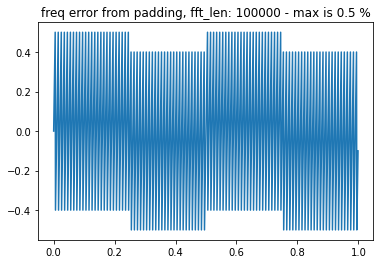

In [ ]:
#from v0.3 but backward: freq from phase
#freq accuracy at 2000 points ~ 1/1000th better than FFT
#FFT gives 3cm, phase gives <-> 0.003mm
fs = 2000
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts)
f0 = 500.5
n_increments=8000
phases = []
f1s = []
Xpas = []
Ypas = []
resize = 100 #100
#for f1 in [200.6,200.55,200.732,200.8855]:
#for f1o in [.1,.05,.232,.3855]:
for f1o in arange(0,1,0.001):
  f1=f0+f1o
  X = sin(2*pi*f1*T)
  X.resize(fs*resize)
  FFT = fft(X)
  #FFT = DFT_new(X)
  MAG = abs(FFT)
  PHASE = angle(FFT)

  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  PHASE = PHASE[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude) #for peak in sorted_magnitude][0]
  f1_estimate = fpeak/resize
  ph_p = PHASE[fpeak]/pi

  Xpas.append(f1o)
  Ypas.append((f1-f1_estimate)*100)

max_error = max(abs(Ypas))
plt.title(f"freq error from padding, fft_len: {n_fft_points} - max is {max_error:.2g} %")
plt.plot(Xpas, Ypas)
plt.show()

## OLD and crap from here

### v0.3 interpolation of f1 from phase

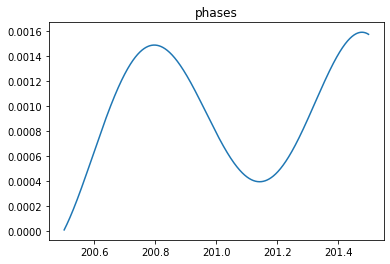

In [ ]:
fs = 1000
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts)
f0 = 200.5
n_increments=2000
phases = []
f1s = []
for f1_offset in range(1,n_increments+1):
  epsilon = f1_offset/n_increments
  f1 = f0+epsilon
  assert fs>f1*2
  Y=sin(2*pi*f1*T)
  FFT = fft(Y)
  MAG = abs(FFT)
  ANG = angle(FFT)
  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  ANG = ANG[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude)
  ph_peak = ANG[fpeak]
  f1s.append(f1)
  phases.append(ph_peak+pi+epsilon*pi*(-1+1/n_increments)) #+pi*()
plt.title("phases")
plt.plot(f1s[2:],phases[2:])
plt.show()

### v0.2 - check validity of dft_resp
seems that :
1. dft_resp accuracy increases as f1 increases
2. not really impacted by fs

FFT len 100
Peak at: 50
MAG-5 delta -0.092 %
MAG-6 delta 0.82 %
199.0


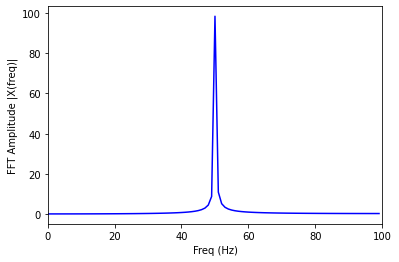

In [ ]:
# sampling rate
fs = 200 #(2kHz)
# sampling interval
ts = 1.0/fs
Tmax = 1
T = arange(0,Tmax,ts) #Time vector
ns = int(len(T)) #number samples
Freqs = arange(0,fs,fs/ns)

exponent=2
fpeaks=[]
FFT, MAG, PHASE = None, None, None
for f1 in [50.1]:
  #f1 = 5.1
  X = sin(2*pi*f1*T)
  FFT = fft(X)
  #FFT = DFT_new(X)
  MAG = abs(FFT)
  PHASE = angle(FFT)

  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  PHASE = PHASE[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude) #for peak in sorted_magnitude][0]
  fp = MAG[fpeak]
  ph_p = PHASE[fpeak]/pi
  fpeaks.append(fp)

print("FFT len",len(MAG))
print("Peak at:",fpeak)
bin0=fpeak
theo_mag,theo_ang=dft_resp(bin0,f1,n_fft_points)
error = (abs(MAG[bin0])-abs(theo_mag))/abs(theo_mag)
print(f"MAG-5 delta {error*100:.2g} %")
bin1=fpeak+1
theo_mag,theo_ang=dft_resp(bin1,f1,n_fft_points)
error = (abs(MAG[bin1])-abs(theo_mag))/abs(theo_mag)
print(f"MAG-6 delta {error*100:.2g} %")

print(Freqs[-1])
plt.plot(Freqs[:n_fft_points],MAG,'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,fpeak*2)

plt.show()


12 1999
15 1.0
10 2000 2000 0.9995 1999.0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


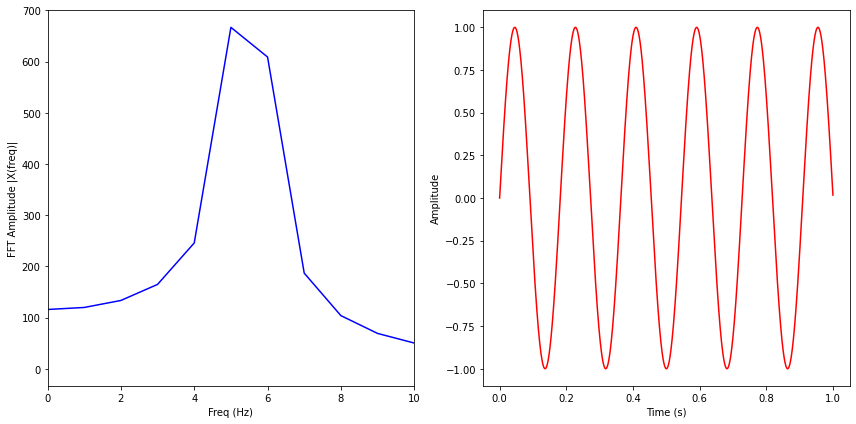

In [ ]:
from numpy.fft import fft, ifft
# sampling rate
sr = 2000
# sampling interval
ts = 1.0/sr
t = arange(0,1,ts)
x = sin(2*pi*5.5*t)
X = fft(x)
N = len(X)

n = arange(N)
print(12,n[-1])
T = N/sr
freq = n/T #=n/N*sr=n/n*sr
print(15,T)
print(10,len(X),len(t),t[-1],freq[-1])

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq, abs(X), 'b') #, \
         #markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
#k1 = k-m
#m=k+1-
phase = pi*k1 -pi*k1/N


## FFT padding

FFT len 10000
Peak at: 50.05 50.05
38 0.0
0.0
MAG-N delta 0 %
10000
len Freqs 200
len MAG 10000


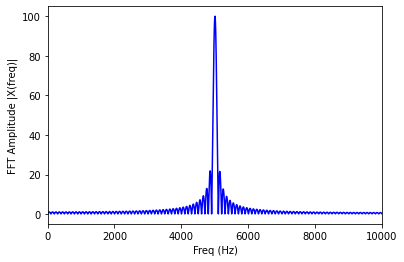

In [ ]:
from matplotlib.backend_bases import ResizeEvent
# sampling rate
fs = 200 #(2kHz)
# sampling interval
ts = 1.0/fs
t_max = 1
T = arange(0,t_max,ts) #Time vector
n_samples = int(len(T)) #number samples
Freqs = arange(0,fs,fs/n_samples)

FFT, MAG, PHASE = None, None, None
resize=100
for f in [50.05]:
  f1 = f
  X = sin(2*pi*f1*T)
  X.resize(fs*resize)
  FFT = fft(X)
  #FFT = DFT_new(X)
  MAG = abs(FFT)
  PHASE = angle(FFT)

  n_fft_points = int(len(MAG)/2)

  MAG = MAG[0:n_fft_points]
  PHASE = PHASE[0:n_fft_points]

  Npeaks=1
  sorted_magnitude = sorted(MAG,reverse = True)
  sorted_magnitude = sorted_magnitude[:Npeaks][0]
  fpeak = list(MAG).index(sorted_magnitude) #for peak in sorted_magnitude][0]
  fp = MAG[fpeak]
  ph_p = PHASE[fpeak]/pi
  fpeaks.append(fp)

print("FFT len",len(MAG))
print("Peak at:",fpeak/resize,f1)
error = (fpeak/resize-abs(f1))/abs(f1)
print(38,fpeak/resize-f1)
print(error)
print(f"MAG-N delta {error*100:.2g} %")

print(n_fft_points)
print("len Freqs",len(Freqs))
print("len MAG",len(MAG))
Freqs = arange(0,fs*1000,fs/n_samples)
plt.plot(Freqs[:n_fft_points],MAG,'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,fpeak*2)

plt.show()

### SPECTROGRAM

### FFT SPECTROGRAM

In [ ]:
from numpy.fft import fft, ifft,fftfreq
from numpy import abs, angle, arange, dot, exp, sin, pi
import matplotlib.pyplot as plt
from numpy import exp

from scipy.signal import spectrogram
from scipy import signal

498 502 2


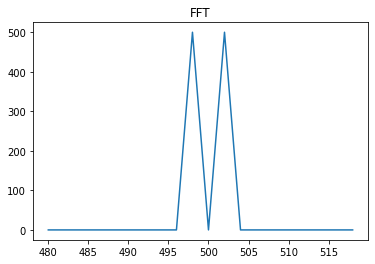

In [ ]:
df_max = 0.7 # non-resolved
df_min = 0.8 # resolved
f0, df = 500, 2
f1, f2 = f0-df, f0+df
n_fft = 1000 #FFT points
fs= 2000 #sampling frequency
T = arange(0,n_fft/fs,1/fs)
# Nyquist
assert fs> max(f1,f2)*2
Y = sin(2*pi*f1*T) + sin(2*pi*f2*T)
FFT = fft(Y)
MAG = abs(FFT)
PHASE = angle(FFT)
n_fft_points = int(len(T)/2)
F = [fs*i/2/n_fft_points for i in range(n_fft_points)]
print(f1,f2,df)

MAG = MAG[0:n_fft_points]
PHASE = PHASE[0:n_fft_points]
plt.title("FFT")
fmin, fmax = int((f0-20)/2), int((f0+20)/2)
plt.plot(F[fmin: fmax], MAG[fmin: fmax]) # [min, max],MAG[min, max])

## CROSS CORRELATION
works great when delta f > 1 frequency bin

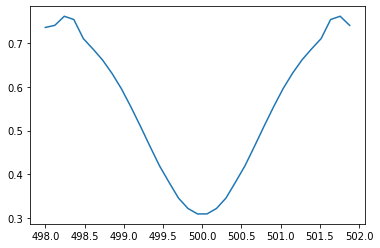

In [ ]:
## CROSS CORRELATION WORKS great down to 1 frequency bin but not below
FREQS = arange(498,502,fs/n_fft_points/33)


import numpy as np

def cross_corr(y1, y2):
  """Calculates the cross correlation and lags without normalization.

  The definition of the discrete cross-correlation is in:
  https://www.mathworks.com/help/matlab/ref/xcorr.html

  Args:
    y1, y2: Should have the same length.

  Returns:
    max_corr: Maximum correlation without normalization.
    lag: The lag in terms of the index.
  """
  if len(y1) != len(y2):
    raise ValueError('The lengths of the inputs should be the same.')

  y1_auto_corr = np.dot(y1, y1) / len(y1)
  y2_auto_corr = np.dot(y2, y2) / len(y1)
  corr = np.correlate(y1, y2, mode='same')
  # The unbiased sample size is N - lag.
  unbiased_sample_size = np.correlate(
      np.ones(len(y1)), np.ones(len(y1)), mode='same')
  corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
  shift = len(y1) // 2

  max_corr = np.max(corr)
  argmax_corr = np.argmax(corr)
  return max_corr, argmax_corr - shift

CORRs = []

for f in FREQS:
  SINE = sin(2*pi*f*T)
  # CORR = [(SINE[i]*Y[i])**2 for i in range(len(T))]
  # corr = sum(CORR)
  # CORRs.append(corr)

  max_corr, _ = cross_corr(Y,SINE)
  CORRs.append(max_corr)

plt.plot(FREQS, CORRs)




In [ ]:
from numpy import angle, exp, pi
i = exp(1j*pi)
print(i)
print(angle(i))

(-1+1.2246467991473532e-16j)
3.141592653589793
